<a href="https://colab.research.google.com/github/ShefaliShettyy/mlproject/blob/main/CredBraine_Telco_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, RepeatedStratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kurtosis, skew, entropy
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
## Loading Data ##
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# response
response_df = pd.read_json('/mydrive/Telco Data/response_trainingset.php')
response_df.set_index('id',inplace=True)
# profile
profile_df = pd.read_json('/mydrive/Telco Data/profile_trainingset.php')
profile_df.set_index('id',inplace=True)

# call detail record
cdr_df = pd.read_json('/mydrive/Telco Data/cdr_trainingset.php')

# payment
payment_df = pd.read_json('/mydrive/Telco Data/payment_trainingset.php')
order_col = ['callingnum','status','timestamp','spending','topup','balance']
payment_df = payment_df[order_col]
payment_df = payment_df.sort_values(['callingnum','timestamp'],ascending=[True,True])

Mounted at /content/gdrive
 api_collab		    'Jupyter Notebook Backup Data'
'Applied Companies.gsheet'  'My Drive'
 CalculatorDLL		     pan_detection_v2
'Colab Notebooks'	     Project
 Cover_note.pdf		     Pushpak_Naik_CV.pdf
 darknet		     pythonProject
 experience		     python_wrapper_for_cppdll
 images			    'Telco Data'


In [ ]:
# payment : spending
sum_ = payment_df.groupby(['callingnum'])['spending'].sum()
count_ = payment_df.groupby(['callingnum'])['spending'].count()
mean_ = sum_/count_
std_ = payment_df.groupby(['callingnum'])['spending'].std()
coefvar_ = std_/mean_
skewness_ = payment_df.groupby(['callingnum'])['spending'].apply(lambda x: skew(x[~np.isnan(x)]))

spending_concat = pd.concat([sum_, count_, mean_, std_, coefvar_, skewness_],axis=1)
spending_concat.columns = ['spending_sum','spending_count','spending_mean','spending_std','spending_coefvar','spending_skewness']


# payment : topup
sum_ = payment_df.groupby(['callingnum'])['topup'].sum()
count_ = payment_df.groupby(['callingnum'])['topup'].count()
mean_ = sum_/count_
std_ = payment_df.groupby(['callingnum'])['topup'].std()
coefvar_ = std_/mean_
skewness_ = payment_df.groupby(['callingnum'])['topup'].apply(lambda x: skew(x[~np.isnan(x)]))

topup_concat = pd.concat([sum_, count_, mean_, std_, coefvar_, skewness_],axis=1)
topup_concat.columns = ['topup_sum','topup_count','topup_mean','topup_std','topup_coefvar','topup_skewness']


payment_concat = pd.concat([spending_concat,topup_concat],axis=1).reset_index()
payment_concat.head(5)

,callingnum,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,spending_skewness,topup_sum,topup_count,topup_mean,topup_std,topup_coefvar,topup_skewness
0,611011514,1741.0,885,1.967232,3.333304,1.694414,5.519713,1789.0,18,99.388889,35.380518,0.355981,-0.289365
1,611023937,4212.0,996,4.228916,5.330090,1.260392,2.951966,4222.0,24,175.916667,43.849463,0.249263,0.036708
2,611024651,4030.0,1222,3.297872,5.022274,1.522883,3.868665,4064.0,21,193.523810,60.491007,0.312577,0.059429
3,611037056,3466.0,1553,2.231809,10.708730,4.798228,13.852864,3691.0,13,283.923077,106.822642,0.376238,0.302182
4,611075786,3437.0,879,3.910125,11.389056,2.912709,6.240904,3612.0,18,200.666667,77.000382,0.383723,-0.127595


In [ ]:
# cdr : calling_duration

sum_ = cdr_df.groupby(['callingnum'])['duration'].sum()
count_ = cdr_df.groupby(['callingnum'])['duration'].count()
mean_ = sum_/count_
std_ = cdr_df.groupby(['callingnum'])['duration'].std()
coefvar_ = std_/mean_
skewness_  = cdr_df.groupby(['callingnum'])['duration'].apply(lambda x: skew(x[~np.isnan(x)]))

calling_concat = pd.concat([sum_, count_, mean_, std_, coefvar_, skewness_],axis=1,join='outer')
calling_concat.columns = ['calling_dur_sum','calling_dur_count','calling_dur_mean','calling_dur_std','calling_dur_coefvar','calling_dur_skewness']


calling_enpropy_location = cdr_df.groupby(['callingnum','location'])['duration'].count().reset_index()
calling_enpropy_location = calling_enpropy_location.groupby(['callingnum'])['duration'].apply(lambda x: entropy(x))

calling_df = pd.concat([calling_concat,calling_enpropy_location],axis=1).reset_index()
calling_df = calling_df.rename(columns={'duration':'calling_enp_loc'})

calling_df.head(5)

,callingnum,calling_dur_sum,calling_dur_count,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc
0,611011514,1001.1652,885,1.131260,3.440300,3.041122,5.317004,3.108765
1,611023937,3624.3609,996,3.638917,5.387919,1.480638,2.890552,3.133634
2,611024651,3183.6296,1222,2.605262,5.112124,1.962231,3.733558,3.086196
3,611037056,1970.5791,1553,1.268885,10.757992,8.478300,13.779748,3.129912
4,611075786,2690.1893,879,3.060511,11.478879,3.750641,6.176931,3.531176


In [ ]:
res_pro_df = pd.concat([profile_df,response_df],axis=1)
res_pro_df.drop(['paytype'], axis=1,inplace=True)
res_pro_pay_df = pd.merge(left=res_pro_df, right=payment_concat, how='left',left_on='phonenum', right_on='callingnum')
res_pro_pay_cdr_df = pd.merge(left=res_pro_pay_df, right=calling_df, how='left',left_on='phonenum', right_on='callingnum')

print(res_pro_pay_cdr_df.head(5))
print(res_pro_pay_cdr_df['status'])

    phonenum  birthdate  ... calling_dur_skewness  calling_enp_loc
0  817552981   19900425  ...            10.094509         3.024129
1  617216883   19850813  ...             8.443371         3.054703
2  617541020   19750620  ...             3.415888         3.193860
3  813133042   19860805  ...             2.014464         3.095801
4  615231774   19780528  ...            23.139929         2.885763

[5 rows x 26 columns]
0      0
1      1
2      0
3      0
4      0
      ..
995    0
996    1
997    0
998    0
999    0
Name: status, Length: 1000, dtype: int64


In [ ]:

# train_test_split:

y = res_pro_pay_cdr_df['status']
X = res_pro_pay_cdr_df.drop(['status'],axis=1)

X_train,X_test,y_train,y_test,indices_train,indices_test = train_test_split(X,y,res_pro_pay_cdr_df.index,test_size=0.3)

# check
X_train.head(5)


,phonenum,birthdate,gender,province,callingnum_x,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,spending_skewness,topup_sum,topup_count,topup_mean,topup_std,topup_coefvar,topup_skewness,callingnum_y,calling_dur_sum,calling_dur_count,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc
51,614811455,19611203,M,60,614811455,6068.0,1114,5.447038,8.732800,1.603220,3.199430,6318.0,19,332.526316,89.552820,0.269310,-0.341035,614811455,5314.2636,1114,4.770434,8.803116,1.845349,3.156504,3.007852
892,619138855,19720331,M,29,619138855,1327.0,873,1.520046,1.447831,0.952492,4.085275,1338.0,42,31.857143,9.863882,0.309629,0.142905,619138855,617.9848,873,0.707886,1.561897,2.206424,3.684996,2.806823
531,893776404,19540223,M,44,893776404,4409.0,1318,3.345220,7.522980,2.248875,5.366084,4451.0,17,261.823529,84.425437,0.322452,-0.324298,893776404,3346.1590,1318,2.538816,7.633910,3.006879,5.242327,3.168776
190,894855246,19931210,F,52,894855246,3400.0,1412,2.407932,4.912634,2.040188,5.552112,3676.0,22,167.090909,68.072027,0.407395,0.188228,894855246,2213.2416,1412,1.567452,5.022812,3.204445,5.410730,3.362604
891,897785523,19930329,F,80,897785523,5866.0,1164,5.039519,5.481006,1.087605,2.166119,6067.0,25,242.680000,53.177157,0.219125,0.094322,897785523,5237.1579,1164,4.499277,5.522233,1.227360,2.143466,3.019887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,814677250,19710615,F,17,814677250,3170.0,919,3.449402,7.619877,2.209043,4.828155,3188.0,17,187.529412,58.488372,0.311889,0.457569,814677250,2438.1803,919,2.653080,7.708360,2.905439,4.741075,2.664142
762,896779276,19690730,F,81,896779276,2462.0,1350,1.823704,5.762796,3.159941,10.169643,2536.0,13,195.076923,94.716649,0.485535,0.978534,896779276,1166.6724,1350,0.864202,5.823794,6.738928,10.028560,3.083573
599,616670886,19710816,M,81,616670886,2161.0,1271,1.700236,2.241834,1.318543,5.225372,2162.0,29,74.551724,16.277913,0.218344,0.238608,616670886,1124.0779,1271,0.884404,2.329481,2.633955,4.907872,2.930978
971,811421689,19610522,M,54,811421689,2357.0,929,2.537137,11.493203,4.529990,11.818524,2489.0,11,226.272727,89.409273,0.395139,0.276011,811421689,1472.3174,929,1.584841,11.552087,7.289113,11.721016,3.349737


In [ ]:
# profile : year_age
day_age = pd.to_datetime('20141231',format='%Y%m%d') - pd.to_datetime(X_train['birthdate'],format='%Y%m%d')
X_train['age_years'] = np.round(day_age/np.timedelta64(1,'D')/365,2)
print(X_train['age_years'])

51     53.11
892    42.78
531    60.89
190    21.07
891    21.77
       ...  
172    43.58
762    45.45
599    43.41
971    53.65
761    41.13
Name: age_years, Length: 700, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
day_age = pd.to_datetime('20141231',format='%Y%m%d') - pd.to_datetime(X_test['birthdate'],format='%Y%m%d')
X_test['age_years'] = np.round(day_age/np.timedelta64(1,'D')/365,2)
print(X_test['age_years'])

722    55.45
426    53.18
517    22.21
44     36.95
823    42.76
       ...  
606    44.08
654    34.07
274    55.81
55     59.34
34     38.59
Name: age_years, Length: 300, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### profile : generation

<img  align="left" src="pics/generations.png" alt="drawing" width="800"/>

In [ ]:
# profile : generation

def adding_gen(year):
    if year > 2000:
        return 'gen_z'
    elif year > 1980:
        return 'gen_y'
    elif year > 1966:
        return 'gen_x'
    elif year > 1946:
        return 'baby_boomers'
    elif year > 1920:
        return 'silent_gen'
    elif year > 1910:
        return 'greatest_gen'
    else:
        return 'outlier'

X_train['age_gens'] = np.floor(X_train['birthdate']/10000).apply(lambda x : adding_gen(x))
X_test['age_gens'] = np.floor(X_test['birthdate']/10000).apply(lambda x : adding_gen(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
X_train.head(50)
# y_train.head(50)     #status values

,phonenum,birthdate,gender,province,callingnum_x,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,spending_skewness,topup_sum,topup_count,topup_mean,topup_std,topup_coefvar,topup_skewness,callingnum_y,calling_dur_sum,calling_dur_count,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc,age_years,age_gens
51,614811455,19611203,M,60,614811455,6068.0,1114,5.447038,8.732800,1.603220,3.199430,6318.0,19,332.526316,89.552820,0.269310,-0.341035,614811455,5314.2636,1114,4.770434,8.803116,1.845349,3.156504,3.007852,53.11,baby_boomers
892,619138855,19720331,M,29,619138855,1327.0,873,1.520046,1.447831,0.952492,4.085275,1338.0,42,31.857143,9.863882,0.309629,0.142905,619138855,617.9848,873,0.707886,1.561897,2.206424,3.684996,2.806823,42.78,gen_x
531,893776404,19540223,M,44,893776404,4409.0,1318,3.345220,7.522980,2.248875,5.366084,4451.0,17,261.823529,84.425437,0.322452,-0.324298,893776404,3346.1590,1318,2.538816,7.633910,3.006879,5.242327,3.168776,60.89,baby_boomers
190,894855246,19931210,F,52,894855246,3400.0,1412,2.407932,4.912634,2.040188,5.552112,3676.0,22,167.090909,68.072027,0.407395,0.188228,894855246,2213.2416,1412,1.567452,5.022812,3.204445,5.410730,3.362604,21.07,gen_y
891,897785523,19930329,F,80,897785523,5866.0,1164,5.039519,5.481006,1.087605,2.166119,6067.0,25,242.680000,53.177157,0.219125,0.094322,897785523,5237.1579,1164,4.499277,5.522233,1.227360,2.143466,3.019887,21.77,gen_y
79,897142265,19811106,F,56,897142265,1143.0,1017,1.123894,3.703370,3.295125,31.756112,1150.0,15,76.666667,50.885960,0.663730,0.650938,897142265,130.6737,1017,0.128489,3.729477,29.025567,31.742228,3.033815,33.17,gen_y
841,815282398,19630529,F,63,815282398,3193.0,1208,2.643212,2.107552,0.797345,2.327204,3219.0,27,119.222222,21.639233,0.181503,-0.027172,815282398,2546.9745,1208,2.108423,2.111011,1.001228,2.250862,3.034473,51.63,baby_boomers
448,817792776,19901211,F,34,817792776,2692.0,1122,2.399287,2.687918,1.120299,3.622551,2786.0,24,116.083333,29.522161,0.254319,-0.005913,817792776,1962.2089,1122,1.748849,2.777194,1.588012,3.429803,2.962344,24.07,gen_y
193,894042069,19590604,F,26,894042069,9926.0,1077,9.216342,6.467577,0.701751,1.470121,10050.0,26,386.538462,61.935599,0.160231,0.243393,894042069,9410.6325,1077,8.737820,6.443565,0.737434,1.475838,3.097859,55.61,baby_boomers
84,813241029,19580908,M,57,813241029,3243.0,1595,2.033229,7.056647,3.470660,10.995851,3512.0,15,234.133333,90.494567,0.386509,0.094945,813241029,1719.6724,1595,1.078165,7.121376,6.605092,10.862669,2.968238,56.35,baby_boomers


In [ ]:
# profile : mean_encoding

temp = pd.concat([X_train,y_train],axis=1)
# print(temp)
# print("=========================================================")
temp = temp[['province','status']].groupby(['province']).mean().reset_index()
# print(temp)
# print("=========================================================")
province_map_dict = dict(zip(temp['province'],temp['status']))
# print(province_map_dict)
# print("=========================================================")

X_train['province_mean_encoding'] = X_train['province'].apply(lambda x : province_map_dict[x])
# print(X_train['province_mean_encoding'])
# print("=========================================================")

# print(X_train)
# print("=========================================================")

temp_test = pd.concat([X_test,y_test],axis=1)
# print(temp_test)
# print("=========================================================")
# temp_test = temp_test[['province','status']].groupby(['province']).mean().reset_index()
# # print(temp_test)
# # print("=========================================================")
# province_map_dict_test = dict(zip(temp_test['province'],temp_test['status']))
# # print(province_map_dict_test)
# print("=========================================================")
X_test['province_mean_encoding'] = X_test['province'].apply(lambda x : province_map_dict[x])
# X_test['province_mean_encoding'] = X_test['province'].apply(lambda x : province_map_dict_test[x])
# print(X_test['province_mean_encoding'])
# print("=========================================================")

# print(X_test)
# print("=========================================================")

# X_train['province'].isnull()
X_test['province_mean_encoding']

      phonenum  birthdate gender  ...      age_gens  province_mean_encoding  status
51   614811455   19611203      M  ...  baby_boomers                0.000000       0
892  619138855   19720331      M  ...         gen_x                0.000000       0
531  893776404   19540223      M  ...  baby_boomers                0.000000       0
190  894855246   19931210      F  ...         gen_y                0.200000       0
891  897785523   19930329      F  ...         gen_y                0.066667       0
..         ...        ...    ...  ...           ...                     ...     ...
172  814677250   19710615      F  ...         gen_x                0.111111       0
762  896779276   19690730      F  ...         gen_x                0.142857       0
599  616670886   19710816      M  ...         gen_x                0.142857       0
971  811421689   19610522      M  ...  baby_boomers                0.111111       0
761  815371658   19731123      F  ...         gen_x                0.090909 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


51     False
892    False
531    False
190    False
891    False
       ...  
172    False
762    False
599    False
971    False
761    False
Name: province, Length: 700, dtype: bool

In [ ]:
X_test['province_mean_encoding'] = X_test['province'].apply(lambda x : province_map_dict[x])
X_test['province_mean_encoding']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


722    0.111111
426    0.000000
517    0.142857
44     0.272727
823    0.000000
         ...   
606    0.000000
654    0.250000
274    0.200000
55     0.230769
34     0.333333
Name: province_mean_encoding, Length: 300, dtype: float64

In [ ]:
X_train

,phonenum,birthdate,gender,province,callingnum_x,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,spending_skewness,topup_sum,topup_count,topup_mean,topup_std,topup_coefvar,topup_skewness,callingnum_y,calling_dur_sum,calling_dur_count,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc,age_years,age_gens,province_mean_encoding
845,816891489,19850828,M,27,816891489,4284.0,1292,3.315789,5.462722,1.647488,4.404005,4370.0,19,230.000000,78.494161,0.341279,-0.099514,816891489,3343.1705,1292,2.587593,5.567993,2.151804,4.266052,2.910470,29.36,gen_y,0.100000
93,613761444,19831110,M,66,613761444,4682.0,1239,3.778854,5.277548,1.396600,3.295487,4722.0,20,236.100000,65.901761,0.279126,0.001266,613761444,3870.3237,1239,3.123748,5.358921,1.715542,3.211265,2.825007,31.16,gen_y,0.222222
300,616021826,19820911,M,59,616021826,2336.0,685,3.410219,4.814046,1.411653,3.121014,2346.0,21,111.714286,26.737881,0.239342,-0.119364,616021826,1881.4276,685,2.746610,4.901045,1.784398,3.041879,2.762418,32.33,gen_y,0.166667
502,613077435,19920612,F,75,613077435,3190.0,949,3.361433,6.596015,1.962263,4.584468,3260.0,23,141.739130,49.515119,0.349340,0.341727,613077435,2459.8395,949,2.592033,6.673878,2.574766,4.493774,2.764444,22.57,gen_y,0.083333
434,817387934,19930126,M,18,817387934,7799.0,1207,6.461475,7.925543,1.226584,2.916036,8122.0,14,580.142857,71.571220,0.123368,-0.012734,817387934,7130.6657,1207,5.907759,7.964767,1.348187,2.895491,3.309199,21.94,gen_y,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,897345918,19931222,F,78,897345918,11261.0,1235,9.118219,4.967540,0.544793,1.052594,11384.0,28,406.571429,55.684580,0.136961,0.301650,897345918,10628.2681,1235,8.605885,4.953540,0.575599,1.067572,3.306375,21.04,gen_y,0.200000
495,817474707,19560708,M,40,817474707,2351.0,1341,1.753169,3.423939,1.953000,6.856278,2356.0,19,124.000000,43.552012,0.351226,-0.043683,817474707,1140.6180,1341,0.850573,3.520346,4.138795,6.653580,3.184692,58.52,baby_boomers,0.000000
977,891673196,19810121,M,16,891673196,2404.0,1396,1.722063,4.360474,2.532122,10.033847,2526.0,15,168.400000,59.460431,0.353090,-0.068768,891673196,1112.5407,1396,0.796949,4.441021,5.572529,9.799285,2.938310,33.96,gen_y,0.250000
959,818525977,19760602,F,19,818525977,4200.0,928,4.525862,5.063926,1.118886,2.432663,4263.0,22,193.772727,45.105096,0.232773,0.070340,818525977,3679.4235,928,3.964896,5.104273,1.287366,2.396348,2.909400,38.61,gen_x,0.333333


In [ ]:
# profile : one-hot encoding

cat_col = ['gender','age_gens']
X_train_onehot = pd.get_dummies(X_train, prefix_sep="_",columns=cat_col)
X_test_onehot = pd.get_dummies(X_test, prefix_sep="_",columns=cat_col)
# X_test = pd.get_dummies(X_test, prefix_sep="_",columns=cat_col)


In [ ]:
# drop some columns

basic_drop_col = ['birthdate','phonenum','province','callingnum_x','callingnum_y','calling_dur_count']

X_train_onehot.drop(basic_drop_col,axis=1,inplace=True)
X_test_onehot.drop(basic_drop_col,axis=1,inplace=True)
print(X_train_onehot)
print(X_test_onehot)

     spending_sum  spending_count  ...  age_gens_gen_x  age_gens_gen_y
845        4284.0            1292  ...               0               1
93         4682.0            1239  ...               0               1
300        2336.0             685  ...               0               1
502        3190.0             949  ...               0               1
434        7799.0            1207  ...               0               1
..            ...             ...  ...             ...             ...
127       11261.0            1235  ...               0               1
495        2351.0            1341  ...               0               0
977        2404.0            1396  ...               0               1
959        4200.0             928  ...               1               0
455        1882.0            1137  ...               0               0

[700 rows x 25 columns]
     spending_sum  spending_count  ...  age_gens_gen_x  age_gens_gen_y
791        5466.0            1220  ...              

In [ ]:
## scope model
# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels

import random
from time import time

def cross_val(learner,X_train, y_train):
    results = {}

    # fiting
    start = time()
    scores = cross_val_score(learner, X_train, y_train, cv=10, scoring='roc_auc',n_jobs=-1)
    # 'roc_auc','f1','precision','recall'
    end = time()

    results['train_time'] = np.round(end-start,4)
    results['scores'] = np.round(np.mean(scores),4)
    return results


In [ ]:
# # TODO: Import the three supervised learning models from sklearn
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel
# sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
# sel.fit(X_train_onehot, y_train)
# select_feat = X_train_onehot.columns[(sel.get_support())]
# print(len(select_feat))
# print(select_feat)
# pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [ ]:
# # selected_features = select_feat
# selected_features = ['spending_count', 'spending_std', 'topup_mean', 'topup_std',
#        'topup_coefvar', 'topup_skewness', 'calling_dur_std', 'calling_enp_loc',
#        'age_years', 'province_mean_encoding']


In [ ]:

X_train_onehot

,spending_sum,spending_count,spending_mean,spending_std,spending_coefvar,spending_skewness,topup_sum,topup_count,topup_mean,topup_std,topup_coefvar,topup_skewness,calling_dur_sum,calling_dur_mean,calling_dur_std,calling_dur_coefvar,calling_dur_skewness,calling_enp_loc,age_years,province_mean_encoding,gender_F,gender_M,age_gens_baby_boomers,age_gens_gen_x,age_gens_gen_y
845,4284.0,1292,3.315789,5.462722,1.647488,4.404005,4370.0,19,230.000000,78.494161,0.341279,-0.099514,3343.1705,2.587593,5.567993,2.151804,4.266052,2.910470,29.36,0.100000,0,1,0,0,1
93,4682.0,1239,3.778854,5.277548,1.396600,3.295487,4722.0,20,236.100000,65.901761,0.279126,0.001266,3870.3237,3.123748,5.358921,1.715542,3.211265,2.825007,31.16,0.222222,0,1,0,0,1
300,2336.0,685,3.410219,4.814046,1.411653,3.121014,2346.0,21,111.714286,26.737881,0.239342,-0.119364,1881.4276,2.746610,4.901045,1.784398,3.041879,2.762418,32.33,0.166667,0,1,0,0,1
502,3190.0,949,3.361433,6.596015,1.962263,4.584468,3260.0,23,141.739130,49.515119,0.349340,0.341727,2459.8395,2.592033,6.673878,2.574766,4.493774,2.764444,22.57,0.083333,1,0,0,0,1
434,7799.0,1207,6.461475,7.925543,1.226584,2.916036,8122.0,14,580.142857,71.571220,0.123368,-0.012734,7130.6657,5.907759,7.964767,1.348187,2.895491,3.309199,21.94,0.066667,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,11261.0,1235,9.118219,4.967540,0.544793,1.052594,11384.0,28,406.571429,55.684580,0.136961,0.301650,10628.2681,8.605885,4.953540,0.575599,1.067572,3.306375,21.04,0.200000,1,0,0,0,1
495,2351.0,1341,1.753169,3.423939,1.953000,6.856278,2356.0,19,124.000000,43.552012,0.351226,-0.043683,1140.6180,0.850573,3.520346,4.138795,6.653580,3.184692,58.52,0.000000,0,1,1,0,0
977,2404.0,1396,1.722063,4.360474,2.532122,10.033847,2526.0,15,168.400000,59.460431,0.353090,-0.068768,1112.5407,0.796949,4.441021,5.572529,9.799285,2.938310,33.96,0.250000,0,1,0,0,1
959,4200.0,928,4.525862,5.063926,1.118886,2.432663,4263.0,22,193.772727,45.105096,0.232773,0.070340,3679.4235,3.964896,5.104273,1.287366,2.396348,2.909400,38.61,0.333333,1,0,0,1,0


In [ ]:
# X_train_onehot = X_train_onehot[selected_features]
# X_test_onehot = X_test_onehot[selected_features]
# X_train_onehot['province_mean_encoding'].max()
# X_train_onehot.value_counts()
X_train_onehot[X_train_onehot['province_mean_encoding']<0.25].value_counts()

spending_sum  spending_count  spending_mean  spending_std  spending_coefvar  spending_skewness  topup_sum  topup_count  topup_mean  topup_std   topup_coefvar  topup_skewness  calling_dur_sum  calling_dur_mean  calling_dur_std  calling_dur_coefvar  calling_dur_skewness  calling_enp_loc  age_years  province_mean_encoding  gender_F  gender_M  age_gens_baby_boomers  age_gens_gen_x  age_gens_gen_y
15094.0       1156            13.057093      6.357341      0.486888          1.005693           15087.0    29           520.241379  57.031104   0.109624        0.288538       14521.7788       12.562092         6.353412         0.505761             1.022645              3.059949         25.07      0.222222                0         1         0                      0               1                 1
2633.0        1211            2.174236       8.342970      3.837196          12.772742          2717.0     14           194.071429  81.231355   0.418564        0.822134       1502.8540        1.241002   

In [ ]:
#Binning of X_train_onehot
X_train_onehot['spending_sum:<=1900'] = np.where((X_train_onehot['spending_sum'] <= 1900), 1, 0)
X_train_onehot['spending_sum:1900-2600'] = np.where((X_train_onehot['spending_sum'] > 1900) & (X_train_onehot['spending_sum'] <= 2600), 1, 0)
X_train_onehot['spending_sum:2600-3500'] = np.where((X_train_onehot['spending_sum'] > 2600) & (X_train_onehot['spending_sum'] <= 3500), 1, 0)
X_train_onehot['spending_sum:3500-4400'] = np.where((X_train_onehot['spending_sum'] > 3500) & (X_train_onehot['spending_sum'] <= 4400), 1, 0)
X_train_onehot['spending_sum:4400-6100'] = np.where((X_train_onehot['spending_sum'] > 4400) & (X_train_onehot['spending_sum'] <= 6100), 1, 0)
X_train_onehot['spending_sum:>6100'] = np.where((X_train_onehot['spending_sum'] > 6100), 1, 0)

X_train_onehot['spending_count:<=840'] = np.where((X_train_onehot['spending_count'] <= 840), 1, 0)
X_train_onehot['spending_count:840-970'] = np.where((X_train_onehot['spending_count'] > 840) & (X_train_onehot['spending_count'] <=970), 1, 0)
X_train_onehot['spending_count:970-1050'] = np.where((X_train_onehot['spending_count'] > 970) & (X_train_onehot['spending_count'] <= 1050), 1, 0)
X_train_onehot['spending_count:1050-1170'] = np.where((X_train_onehot['spending_count'] > 1050) & (X_train_onehot['spending_count'] <= 1170), 1, 0)
X_train_onehot['spending_count:1170-1290'] = np.where((X_train_onehot['spending_count'] > 1170) & (X_train_onehot['spending_count'] <= 1290), 1, 0)
X_train_onehot['spending_count:>1290'] = np.where((X_train_onehot['spending_count'] > 1290), 1, 0)

X_train_onehot['spending_mean:<=2'] = np.where((X_train_onehot['spending_mean'] <= 2), 1, 0)
X_train_onehot['spending_mean:2-2.8'] = np.where((X_train_onehot['spending_mean'] > 2) & (X_train_onehot['spending_mean'] <=2.8), 1, 0)
X_train_onehot['spending_mean:2.8-3.6'] = np.where((X_train_onehot['spending_mean'] > 2.8) & (X_train_onehot['spending_mean'] <=3.6), 1, 0)
X_train_onehot['spending_mean:3.6-4.9'] = np.where((X_train_onehot['spending_mean'] > 3.6) & (X_train_onehot['spending_mean'] <=4.9), 1, 0)
X_train_onehot['spending_mean:>4.9'] = np.where((X_train_onehot['spending_mean'] > 4.9), 1, 0)

X_train_onehot['spending_std:<=2.7'] = np.where((X_train_onehot['spending_std'] <= 2.7), 1, 0)
X_train_onehot['spending_std:2.7-4.3'] = np.where((X_train_onehot['spending_std'] > 2.7) & (X_train_onehot['spending_std'] <= 4.3), 1, 0)
X_train_onehot['spending_std:4.3-5.8'] = np.where((X_train_onehot['spending_std'] > 4.3) & (X_train_onehot['spending_std'] <= 5.8), 1, 0)
X_train_onehot['spending_std:5.8-7.9'] = np.where((X_train_onehot['spending_std'] > 5.8) & (X_train_onehot['spending_std'] <= 7.9), 1, 0)
X_train_onehot['spending_std:>7.9'] = np.where((X_train_onehot['spending_std'] > 7.9), 1, 0)

X_train_onehot['spending_coefvar:<=0.8'] = np.where((X_train_onehot['spending_coefvar'] <= 0.8), 1, 0)
X_train_onehot['spending_coefvar:0.8-1.3'] = np.where((X_train_onehot['spending_coefvar'] > 0.8) & (X_train_onehot['spending_coefvar'] <= 1.3), 1, 0)
X_train_onehot['spending_coefvar:1.3-1.9'] = np.where((X_train_onehot['spending_coefvar'] > 1.3) & (X_train_onehot['spending_coefvar'] <= 1.9), 1, 0)
X_train_onehot['spending_coefvar:1.9-2.6'] = np.where((X_train_onehot['spending_coefvar'] > 1.9) & (X_train_onehot['spending_coefvar'] <= 2.6), 1, 0)
X_train_onehot['spending_coefvar:>2.6'] = np.where((X_train_onehot['spending_coefvar'] > 2.6), 1, 0)

X_train_onehot['spending_skewness:<=1.9'] = np.where((X_train_onehot['spending_skewness'] <= 1.9), 1, 0)
X_train_onehot['spending_skewness:1.9-3.3'] = np.where((X_train_onehot['spending_skewness'] > 1.9) & (X_train_onehot['spending_skewness'] <= 3.3), 1, 0)
X_train_onehot['spending_skewness:3.3-5.2'] = np.where((X_train_onehot['spending_skewness'] > 3.3) & (X_train_onehot['spending_skewness'] <= 5.2), 1, 0)
X_train_onehot['spending_skewness:5.2-8.4'] = np.where((X_train_onehot['spending_skewness'] > 5.2) & (X_train_onehot['spending_skewness'] <= 8.4), 1, 0)
X_train_onehot['spending_skewness:>8.4'] = np.where((X_train_onehot['spending_skewness'] > 8.4), 1, 0)

X_train_onehot['topup_sum:<=2100'] = np.where((X_train_onehot['topup_sum'] <= 2100), 1, 0)
X_train_onehot['topup_sum:2100-2900'] = np.where((X_train_onehot['topup_sum'] > 2100) & (X_train_onehot['topup_sum'] <= 2900), 1, 0)
X_train_onehot['topup_sum:2900-3900'] = np.where((X_train_onehot['topup_sum'] > 2900) & (X_train_onehot['topup_sum'] <= 3900), 1, 0)
X_train_onehot['topup_sum:3900-5500'] = np.where((X_train_onehot['topup_sum'] > 3900) & (X_train_onehot['topup_sum'] <= 5500), 1, 0)
X_train_onehot['topup_sum:>5500'] = np.where((X_train_onehot['topup_sum'] > 5500), 1, 0)

X_train_onehot['topup_count:<=16'] = np.where((X_train_onehot['topup_count'] <= 16), 1, 0)
X_train_onehot['topup_count:16-19'] = np.where((X_train_onehot['topup_count'] > 16) & (X_train_onehot['topup_count'] <= 19), 1, 0)
X_train_onehot['topup_count:19-24'] = np.where((X_train_onehot['topup_count'] > 19) & (X_train_onehot['topup_count'] <= 24), 1, 0)
X_train_onehot['topup_count:24-28'] = np.where((X_train_onehot['topup_count'] > 24) & (X_train_onehot['topup_count'] <= 28), 1, 0)
X_train_onehot['topup_count:>28'] = np.where((X_train_onehot['topup_count'] > 28), 1, 0)

X_train_onehot['topup_mean:<=110'] = np.where((X_train_onehot['topup_mean'] <= 110), 1, 0)
X_train_onehot['topup_mean:110-155'] = np.where((X_train_onehot['topup_mean'] > 110) & (X_train_onehot['topup_mean'] <= 155), 1, 0)
X_train_onehot['topup_mean:155-200'] = np.where((X_train_onehot['topup_mean'] > 155) & (X_train_onehot['topup_mean'] <= 200), 1, 0)
X_train_onehot['topup_mean:200-260'] = np.where((X_train_onehot['topup_mean'] > 200) & (X_train_onehot['topup_mean'] <= 260), 1, 0)
X_train_onehot['topup_mean:>260'] = np.where((X_train_onehot['topup_mean'] > 260), 1, 0)

X_train_onehot['topup_std:<=26'] = np.where((X_train_onehot['topup_std'] <= 26), 1, 0)
X_train_onehot['topup_std:26-40'] = np.where((X_train_onehot['topup_std'] > 26) & (X_train_onehot['topup_std'] <= 40), 1, 0)
X_train_onehot['topup_std:40-57'] = np.where((X_train_onehot['topup_std'] > 40) & (X_train_onehot['topup_std'] <= 57), 1, 0)
X_train_onehot['topup_std:57-80'] = np.where((X_train_onehot['topup_std'] > 57) & (X_train_onehot['topup_std'] <= 80), 1, 0)
X_train_onehot['topup_std:>80'] = np.where((X_train_onehot['topup_std'] > 80), 1, 0)

X_train_onehot['topup_coefvar:<=0.18'] = np.where((X_train_onehot['topup_coefvar'] <= 0.18), 1, 0)
X_train_onehot['topup_coefvar:0.18-0.25'] = np.where((X_train_onehot['topup_coefvar'] > 0.18) & (X_train_onehot['topup_coefvar'] <= 0.25), 1, 0)
X_train_onehot['topup_coefvar:0.25-0.39'] = np.where((X_train_onehot['topup_coefvar'] > 0.25) & (X_train_onehot['topup_coefvar'] <= 0.39), 1, 0)
X_train_onehot['topup_coefvar:0.39-0.40'] = np.where((X_train_onehot['topup_coefvar'] > 0.39) & (X_train_onehot['topup_coefvar'] <= 0.40), 1, 0)
X_train_onehot['topup_coefvar:>0.40'] = np.where((X_train_onehot['topup_coefvar'] > 0.40), 1, 0)

X_train_onehot['topup_skewness:<=-0.27'] = np.where((X_train_onehot['topup_skewness'] <= -0.27), 1, 0)
X_train_onehot['topup_skewness:-0.27--0.06'] = np.where((X_train_onehot['topup_skewness'] > -0.27) & (X_train_onehot['topup_skewness'] <= -0.06), 1, 0)
X_train_onehot['topup_skewness:-0.06-0.09'] = np.where((X_train_onehot['topup_skewness'] >-0.06) & (X_train_onehot['topup_skewness'] <= 0.09), 1, 0)
X_train_onehot['topup_skewness:0.09-0.3'] = np.where((X_train_onehot['topup_skewness'] > 0.09) & (X_train_onehot['topup_skewness'] <= 0.3), 1, 0)
X_train_onehot['topup_skewness:>0.3'] = np.where((X_train_onehot['topup_skewness'] > 0.3), 1, 0)

X_train_onehot['calling_dur_sum:<=1250'] = np.where((X_train_onehot['calling_dur_sum'] <= 1250), 1, 0)
X_train_onehot['calling_dur_sum:1250-2100'] = np.where((X_train_onehot['calling_dur_sum'] > 1250) & (X_train_onehot['calling_dur_sum'] <= 2100), 1, 0)
X_train_onehot['calling_dur_sum:2100-3000'] = np.where((X_train_onehot['calling_dur_sum'] > 2100) & (X_train_onehot['calling_dur_sum'] <= 3000), 1, 0)
X_train_onehot['calling_dur_sum:3000-4700'] = np.where((X_train_onehot['calling_dur_sum'] > 3000) & (X_train_onehot['calling_dur_sum'] <= 4700), 1, 0)
X_train_onehot['calling_dur_sum:>4700'] = np.where((X_train_onehot['calling_dur_sum'] > 4700), 1, 0)

X_train_onehot['calling_dur_mean:<=1.2'] = np.where((X_train_onehot['calling_dur_mean'] <= 1.2), 1, 0)
X_train_onehot['calling_dur_mean:1.2-2.1'] = np.where((X_train_onehot['calling_dur_mean'] > 1.2) & (X_train_onehot['calling_dur_mean'] <= 2.1), 1, 0)
X_train_onehot['calling_dur_mean:2.1-2.9'] = np.where((X_train_onehot['calling_dur_mean'] > 2.1) & (X_train_onehot['calling_dur_mean'] <= 2.9), 1, 0)
X_train_onehot['calling_dur_mean:2.9-4.4'] = np.where((X_train_onehot['calling_dur_mean'] > 2.9) & (X_train_onehot['calling_dur_mean'] <= 4.4), 1, 0)
X_train_onehot['calling_dur_mean:>4.4'] = np.where((X_train_onehot['calling_dur_mean'] > 4.4), 1, 0)

X_train_onehot['calling_dur_std:<=2.7'] = np.where((X_train_onehot['calling_dur_std'] <= 2.7), 1, 0)
X_train_onehot['calling_dur_std:2.7-4.2'] = np.where((X_train_onehot['calling_dur_std'] > 2.7) & (X_train_onehot['calling_dur_std'] <= 4.2), 1, 0)
X_train_onehot['calling_dur_std:4.2-5.8'] = np.where((X_train_onehot['calling_dur_std'] > 4.2) & (X_train_onehot['calling_dur_std'] <= 5.8), 1, 0)
X_train_onehot['calling_dur_std:5.8-7.9'] = np.where((X_train_onehot['calling_dur_std'] > 5.8) & (X_train_onehot['calling_dur_std'] <= 7.9), 1, 0)
X_train_onehot['calling_dur_std:>7.9'] = np.where((X_train_onehot['calling_dur_std'] > 7.9), 1, 0)

X_train_onehot['calling_dur_coefvar:<=0.9'] = np.where((X_train_onehot['calling_dur_coefvar'] <= 0.9), 1, 0)
X_train_onehot['calling_dur_coefvar:0.9-1.62'] = np.where((X_train_onehot['calling_dur_coefvar'] > 0.9) & (X_train_onehot['calling_dur_coefvar'] <= 1.62), 1, 0)
X_train_onehot['calling_dur_coefvar:1.62-2.6'] = np.where((X_train_onehot['calling_dur_coefvar'] > 1.62) & (X_train_onehot['calling_dur_coefvar'] <= 2.6), 1, 0)
X_train_onehot['calling_dur_coefvar:2.6-4.4'] = np.where((X_train_onehot['calling_dur_coefvar'] > 2.6) & (X_train_onehot['calling_dur_coefvar'] <= 4.4), 1, 0)
X_train_onehot['calling_dur_coefvar:>4.4'] = np.where((X_train_onehot['calling_dur_coefvar'] > 4.4), 1, 0)

X_train_onehot['calling_dur_skewness:<=1.8'] = np.where((X_train_onehot['calling_dur_skewness'] <= 1.8), 1, 0)
X_train_onehot['calling_dur_skewness:1.8-3.1'] = np.where((X_train_onehot['calling_dur_skewness'] > 1.8) & (X_train_onehot['calling_dur_skewness'] <= 3.1), 1, 0)
X_train_onehot['calling_dur_skewness:3.1-4.9'] = np.where((X_train_onehot['calling_dur_skewness'] >3.1) & (X_train_onehot['calling_dur_skewness'] <= 4.9), 1, 0)
X_train_onehot['calling_dur_skewness:4.9-7.9'] = np.where((X_train_onehot['calling_dur_skewness'] > 4.9) & (X_train_onehot['calling_dur_skewness'] <= 7.9), 1, 0)
X_train_onehot['calling_dur_skewness:>7.9'] = np.where((X_train_onehot['calling_dur_skewness'] > 7.9), 1, 0)

X_train_onehot['calling_enp_loc:<=2.9'] = np.where((X_train_onehot['calling_enp_loc'] <= 2.9), 1, 0)
X_train_onehot['calling_enp_loc:2.9-3.05'] = np.where((X_train_onehot['calling_enp_loc'] > 2.9) & (X_train_onehot['calling_enp_loc'] <= 3.05), 1, 0)
X_train_onehot['calling_enp_loc:3.05-3.15'] = np.where((X_train_onehot['calling_enp_loc'] >3.05) & (X_train_onehot['calling_enp_loc'] <= 3.15), 1, 0)
X_train_onehot['calling_enp_loc:3.15-3.27'] = np.where((X_train_onehot['calling_enp_loc'] > 3.15) & (X_train_onehot['calling_enp_loc'] <= 3.27), 1, 0)
X_train_onehot['calling_enp_loc:>3.27'] = np.where((X_train_onehot['calling_enp_loc'] > 3.27), 1, 0)

X_train_onehot['age_years:<=28.5'] = np.where((X_train_onehot['age_years'] <= 28.5), 1, 0)
X_train_onehot['age_years:28.5-36.4'] = np.where((X_train_onehot['age_years'] > 28.5) & (X_train_onehot['age_years'] <= 36.4), 1, 0)
X_train_onehot['age_years:36.4-45'] = np.where((X_train_onehot['age_years'] > 36.4) & (X_train_onehot['age_years'] <= 45), 1, 0)
X_train_onehot['age_years:45-53'] = np.where((X_train_onehot['age_years'] > 45) & (X_train_onehot['age_years'] <= 53), 1, 0)
X_train_onehot['age_years:>53'] = np.where((X_train_onehot['age_years'] > 53), 1, 0)

X_train_onehot['province_mean_encoding:<=0.07'] = np.where((X_train_onehot['province_mean_encoding'] <= 0.07), 1, 0)
X_train_onehot['province_mean_encoding:0.07-0.12'] = np.where((X_train_onehot['province_mean_encoding'] > 0.07) & (X_train_onehot['province_mean_encoding'] <= 0.12), 1, 0)
X_train_onehot['province_mean_encoding:0.12-0.181'] = np.where((X_train_onehot['province_mean_encoding'] > 0.12) & (X_train_onehot['province_mean_encoding'] <= 0.181), 1, 0)
X_train_onehot['province_mean_encoding:0.181-0.25'] = np.where((X_train_onehot['province_mean_encoding'] > 0.181) & (X_train_onehot['province_mean_encoding'] <= 0.25), 1, 0)
X_train_onehot['province_mean_encoding:>0.25'] = np.where((X_train_onehot['province_mean_encoding'] > 0.25), 1, 0)

columns_to_drop = ['spending_sum',	'spending_count',	'spending_mean',	'spending_std',	'spending_coefvar',	'spending_skewness',	'topup_sum',	'topup_count',
                   'topup_mean',	'topup_std',	'topup_coefvar',	'topup_skewness',	'calling_dur_sum',
                   'calling_dur_mean',	'calling_dur_std'	,'calling_dur_coefvar',	'calling_dur_skewness','calling_enp_loc','age_years','province_mean_encoding']
#,'spending_sum:>6100','spending_count:>1290',
 #  'spending_mean:>4.9', 'spending_std:>7.9','spending_coefvar:>2.6','spending_skewness:>8.4','topup_sum:>5500','topup_count:>28','topup_mean:>260',
 #  'topup_std:>80','topup_coefvar:>0.40','topup_skewness:>0.3','calling_dur_sum:>4700','calling_dur_mean:>4.4','calling_dur_std:>7.9','calling_dur_coefvar:>4.4','calling_dur_skewness:>7.9'
X_train_onehot.drop(columns = columns_to_drop, inplace = True)
X_train_onehot

,gender_F,gender_M,age_gens_baby_boomers,age_gens_gen_x,age_gens_gen_y,spending_sum:<=1900,spending_sum:1900-2600,spending_sum:2600-3500,spending_sum:3500-4400,spending_sum:4400-6100,spending_sum:>6100,spending_count:<=840,spending_count:840-970,spending_count:970-1050,spending_count:1050-1170,spending_count:1170-1290,spending_count:>1290,spending_mean:<=2,spending_mean:2-2.8,spending_mean:2.8-3.6,spending_mean:3.6-4.9,spending_mean:>4.9,spending_std:<=2.7,spending_std:2.7-4.3,spending_std:4.3-5.8,spending_std:5.8-7.9,spending_std:>7.9,spending_coefvar:<=0.8,spending_coefvar:0.8-1.3,spending_coefvar:1.3-1.9,spending_coefvar:1.9-2.6,spending_coefvar:>2.6,spending_skewness:<=1.9,spending_skewness:1.9-3.3,spending_skewness:3.3-5.2,spending_skewness:5.2-8.4,spending_skewness:>8.4,topup_sum:<=2100,topup_sum:2100-2900,topup_sum:2900-3900,...,calling_dur_sum:<=1250,calling_dur_sum:1250-2100,calling_dur_sum:2100-3000,calling_dur_sum:3000-4700,calling_dur_sum:>4700,calling_dur_mean:<=1.2,calling_dur_mean:1.2-2.1,calling_dur_mean:2.1-2.9,calling_dur_mean:2.9-4.4,calling_dur_mean:>4.4,calling_dur_std:<=2.7,calling_dur_std:2.7-4.2,calling_dur_std:4.2-5.8,calling_dur_std:5.8-7.9,calling_dur_std:>7.9,calling_dur_coefvar:<=0.9,calling_dur_coefvar:0.9-1.62,calling_dur_coefvar:1.62-2.6,calling_dur_coefvar:2.6-4.4,calling_dur_coefvar:>4.4,calling_dur_skewness:<=1.8,calling_dur_skewness:1.8-3.1,calling_dur_skewness:3.1-4.9,calling_dur_skewness:4.9-7.9,calling_dur_skewness:>7.9,calling_enp_loc:<=2.9,calling_enp_loc:2.9-3.05,calling_enp_loc:3.05-3.15,calling_enp_loc:3.15-3.27,calling_enp_loc:>3.27,age_years:<=28.5,age_years:28.5-36.4,age_years:36.4-45,age_years:45-53,age_years:>53,province_mean_encoding:<=0.07,province_mean_encoding:0.07-0.12,province_mean_encoding:0.12-0.181,province_mean_encoding:0.181-0.25,province_mean_encoding:>0.25
845,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
93,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
300,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
502,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
434,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
495,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
977,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
959,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:

#X_train_onehot[select_feat].info()

reg = LogisticRegression(max_iter=10000, class_weight = 'balanced')

results = {}
clf_name = reg.__class__.__name__
results[clf_name] = cross_val(reg,X_train_onehot, y_train)

print(results)


{'LogisticRegression': {'train_time': 0.3942, 'scores': 0.7451}}


In [ ]:
# pretty impressive scores for the first time, now let's fit the pipeline on the whole training set
reg.fit(X_train_onehot, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [ ]:

# first create a transformed training set through our WoE_Binning custom class
# X_train_woe_transformed = woe_transform.fit_transform(X_train_onehot[selected_features])
# # Store the column names in X_train as a list
# feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
feature_name = X_train_onehot.columns.values

summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table


,Feature name,Coefficients
0,Intercept,-0.999069
1,gender_F,-0.220807
2,gender_M,0.221021
3,age_gens_baby_boomers,0.350263
4,age_gens_gen_x,0.150131
...,...,...
103,province_mean_encoding:<=0.07,-2.498045
104,province_mean_encoding:0.07-0.12,-0.412746
105,province_mean_encoding:0.12-0.181,0.230768
106,province_mean_encoding:0.181-0.25,0.931280


In [ ]:
#Binning of X_test_onehot
X_test_onehot['spending_sum:<=1900'] = np.where((X_test_onehot['spending_sum'] <= 1900), 1, 0)
X_test_onehot['spending_sum:1900-2600'] = np.where((X_test_onehot['spending_sum'] > 1900) & (X_test_onehot['spending_sum'] <= 2600), 1, 0)
X_test_onehot['spending_sum:2600-3500'] = np.where((X_test_onehot['spending_sum'] > 2600) & (X_test_onehot['spending_sum'] <= 3500), 1, 0)
X_test_onehot['spending_sum:3500-4400'] = np.where((X_test_onehot['spending_sum'] > 3500) & (X_test_onehot['spending_sum'] <= 4400), 1, 0)
X_test_onehot['spending_sum:4400-6100'] = np.where((X_test_onehot['spending_sum'] > 4400) & (X_test_onehot['spending_sum'] <= 6100), 1, 0)
X_test_onehot['spending_sum:>6100'] = np.where((X_test_onehot['spending_sum'] > 6100), 1, 0)

X_test_onehot['spending_count:<=840'] = np.where((X_test_onehot['spending_count'] <= 840), 1, 0)
X_test_onehot['spending_count:840-970'] = np.where((X_test_onehot['spending_count'] > 840) & (X_test_onehot['spending_count'] <=970), 1, 0)
X_test_onehot['spending_count:970-1050'] = np.where((X_test_onehot['spending_count'] > 970) & (X_test_onehot['spending_count'] <= 1050), 1, 0)
X_test_onehot['spending_count:1050-1170'] = np.where((X_test_onehot['spending_count'] > 1050) & (X_test_onehot['spending_count'] <= 1170), 1, 0)
X_test_onehot['spending_count:1170-1290'] = np.where((X_test_onehot['spending_count'] > 1170) & (X_test_onehot['spending_count'] <= 1290), 1, 0)
X_test_onehot['spending_count:>1290'] = np.where((X_test_onehot['spending_count'] > 1290), 1, 0)

X_test_onehot['spending_mean:<=2'] = np.where((X_test_onehot['spending_mean'] <= 2), 1, 0)
X_test_onehot['spending_mean:2-2.8'] = np.where((X_test_onehot['spending_mean'] > 2) & (X_test_onehot['spending_mean'] <=2.8), 1, 0)
X_test_onehot['spending_mean:2.8-3.6'] = np.where((X_test_onehot['spending_mean'] > 2.8) & (X_test_onehot['spending_mean'] <=3.6), 1, 0)
X_test_onehot['spending_mean:3.6-4.9'] = np.where((X_test_onehot['spending_mean'] > 3.6) & (X_test_onehot['spending_mean'] <=4.9), 1, 0)
X_test_onehot['spending_mean:>4.9'] = np.where((X_test_onehot['spending_mean'] > 4.9), 1, 0)

X_test_onehot['spending_std:<=2.7'] = np.where((X_test_onehot['spending_std'] <= 2.7), 1, 0)
X_test_onehot['spending_std:2.7-4.3'] = np.where((X_test_onehot['spending_std'] > 2.7) & (X_test_onehot['spending_std'] <= 4.3), 1, 0)
X_test_onehot['spending_std:4.3-5.8'] = np.where((X_test_onehot['spending_std'] > 4.3) & (X_test_onehot['spending_std'] <= 5.8), 1, 0)
X_test_onehot['spending_std:5.8-7.9'] = np.where((X_test_onehot['spending_std'] > 5.8) & (X_test_onehot['spending_std'] <= 7.9), 1, 0)
X_test_onehot['spending_std:>7.9'] = np.where((X_test_onehot['spending_std'] > 7.9), 1, 0)

X_test_onehot['spending_coefvar:<=0.8'] = np.where((X_test_onehot['spending_coefvar'] <= 0.8), 1, 0)
X_test_onehot['spending_coefvar:0.8-1.3'] = np.where((X_test_onehot['spending_coefvar'] > 0.8) & (X_test_onehot['spending_coefvar'] <= 1.3), 1, 0)
X_test_onehot['spending_coefvar:1.3-1.9'] = np.where((X_test_onehot['spending_coefvar'] > 1.3) & (X_test_onehot['spending_coefvar'] <= 1.9), 1, 0)
X_test_onehot['spending_coefvar:1.9-2.6'] = np.where((X_test_onehot['spending_coefvar'] > 1.9) & (X_test_onehot['spending_coefvar'] <= 2.6), 1, 0)
X_test_onehot['spending_coefvar:>2.6'] = np.where((X_test_onehot['spending_coefvar'] > 2.6), 1, 0)

X_test_onehot['spending_skewness:<=1.9'] = np.where((X_test_onehot['spending_skewness'] <= 1.9), 1, 0)
X_test_onehot['spending_skewness:1.9-3.3'] = np.where((X_test_onehot['spending_skewness'] > 1.9) & (X_test_onehot['spending_skewness'] <= 3.3), 1, 0)
X_test_onehot['spending_skewness:3.3-5.2'] = np.where((X_test_onehot['spending_skewness'] > 3.3) & (X_test_onehot['spending_skewness'] <= 5.2), 1, 0)
X_test_onehot['spending_skewness:5.2-8.4'] = np.where((X_test_onehot['spending_skewness'] > 5.2) & (X_test_onehot['spending_skewness'] <= 8.4), 1, 0)
X_test_onehot['spending_skewness:>8.4'] = np.where((X_test_onehot['spending_skewness'] > 8.4), 1, 0)

X_test_onehot['topup_sum:<=2100'] = np.where((X_test_onehot['topup_sum'] <= 2100), 1, 0)
X_test_onehot['topup_sum:2100-2900'] = np.where((X_test_onehot['topup_sum'] > 2100) & (X_test_onehot['topup_sum'] <= 2900), 1, 0)
X_test_onehot['topup_sum:2900-3900'] = np.where((X_test_onehot['topup_sum'] > 2900) & (X_test_onehot['topup_sum'] <= 3900), 1, 0)
X_test_onehot['topup_sum:3900-5500'] = np.where((X_test_onehot['topup_sum'] > 3900) & (X_test_onehot['topup_sum'] <= 5500), 1, 0)
X_test_onehot['topup_sum:>5500'] = np.where((X_test_onehot['topup_sum'] > 5500), 1, 0)

X_test_onehot['topup_count:<=16'] = np.where((X_test_onehot['topup_count'] <= 16), 1, 0)
X_test_onehot['topup_count:16-19'] = np.where((X_test_onehot['topup_count'] > 16) & (X_test_onehot['topup_count'] <= 19), 1, 0)
X_test_onehot['topup_count:19-24'] = np.where((X_test_onehot['topup_count'] > 19) & (X_test_onehot['topup_count'] <= 24), 1, 0)
X_test_onehot['topup_count:24-28'] = np.where((X_test_onehot['topup_count'] > 24) & (X_test_onehot['topup_count'] <= 28), 1, 0)
X_test_onehot['topup_count:>28'] = np.where((X_test_onehot['topup_count'] > 28), 1, 0)

X_test_onehot['topup_mean:<=110'] = np.where((X_test_onehot['topup_mean'] <= 110), 1, 0)
X_test_onehot['topup_mean:110-155'] = np.where((X_test_onehot['topup_mean'] > 110) & (X_test_onehot['topup_mean'] <= 155), 1, 0)
X_test_onehot['topup_mean:155-200'] = np.where((X_test_onehot['topup_mean'] > 155) & (X_test_onehot['topup_mean'] <= 200), 1, 0)
X_test_onehot['topup_mean:200-260'] = np.where((X_test_onehot['topup_mean'] > 200) & (X_test_onehot['topup_mean'] <= 260), 1, 0)
X_test_onehot['topup_mean:>260'] = np.where((X_test_onehot['topup_mean'] > 260), 1, 0)

X_test_onehot['topup_std:<=26'] = np.where((X_test_onehot['topup_std'] <= 26), 1, 0)
X_test_onehot['topup_std:26-40'] = np.where((X_test_onehot['topup_std'] > 26) & (X_test_onehot['topup_std'] <= 40), 1, 0)
X_test_onehot['topup_std:40-57'] = np.where((X_test_onehot['topup_std'] > 40) & (X_test_onehot['topup_std'] <= 57), 1, 0)
X_test_onehot['topup_std:57-80'] = np.where((X_test_onehot['topup_std'] > 57) & (X_test_onehot['topup_std'] <= 80), 1, 0)
X_test_onehot['topup_std:>80'] = np.where((X_test_onehot['topup_std'] > 80), 1, 0)

X_test_onehot['topup_coefvar:<=0.18'] = np.where((X_test_onehot['topup_coefvar'] <= 0.18), 1, 0)
X_test_onehot['topup_coefvar:0.18-0.25'] = np.where((X_test_onehot['topup_coefvar'] > 0.18) & (X_test_onehot['topup_coefvar'] <= 0.25), 1, 0)
X_test_onehot['topup_coefvar:0.25-0.39'] = np.where((X_test_onehot['topup_coefvar'] > 0.25) & (X_test_onehot['topup_coefvar'] <= 0.39), 1, 0)
X_test_onehot['topup_coefvar:0.39-0.40'] = np.where((X_test_onehot['topup_coefvar'] > 0.39) & (X_test_onehot['topup_coefvar'] <= 0.40), 1, 0)
X_test_onehot['topup_coefvar:>0.40'] = np.where((X_test_onehot['topup_coefvar'] > 0.40), 1, 0)

X_test_onehot['topup_skewness:<=-0.27'] = np.where((X_test_onehot['topup_skewness'] <= -0.27), 1, 0)
X_test_onehot['topup_skewness:-0.27--0.06'] = np.where((X_test_onehot['topup_skewness'] > -0.27) & (X_test_onehot['topup_skewness'] <= -0.06), 1, 0)
X_test_onehot['topup_skewness:-0.06-0.09'] = np.where((X_test_onehot['topup_skewness'] >-0.06) & (X_test_onehot['topup_skewness'] <= 0.09), 1, 0)
X_test_onehot['topup_skewness:0.09-0.3'] = np.where((X_test_onehot['topup_skewness'] > 0.09) & (X_test_onehot['topup_skewness'] <= 0.3), 1, 0)
X_test_onehot['topup_skewness:>0.3'] = np.where((X_test_onehot['topup_skewness'] > 0.3), 1, 0)

X_test_onehot['calling_dur_sum:<=1250'] = np.where((X_test_onehot['calling_dur_sum'] <= 1250), 1, 0)
X_test_onehot['calling_dur_sum:1250-2100'] = np.where((X_test_onehot['calling_dur_sum'] > 1250) & (X_test_onehot['calling_dur_sum'] <= 2100), 1, 0)
X_test_onehot['calling_dur_sum:2100-3000'] = np.where((X_test_onehot['calling_dur_sum'] > 2100) & (X_test_onehot['calling_dur_sum'] <= 3000), 1, 0)
X_test_onehot['calling_dur_sum:3000-4700'] = np.where((X_test_onehot['calling_dur_sum'] > 3000) & (X_test_onehot['calling_dur_sum'] <= 4700), 1, 0)
X_test_onehot['calling_dur_sum:>4700'] = np.where((X_test_onehot['calling_dur_sum'] > 4700), 1, 0)

X_test_onehot['calling_dur_mean:<=1.2'] = np.where((X_test_onehot['calling_dur_mean'] <= 1.2), 1, 0)
X_test_onehot['calling_dur_mean:1.2-2.1'] = np.where((X_test_onehot['calling_dur_mean'] > 1.2) & (X_test_onehot['calling_dur_mean'] <= 2.1), 1, 0)
X_test_onehot['calling_dur_mean:2.1-2.9'] = np.where((X_test_onehot['calling_dur_mean'] > 2.1) & (X_test_onehot['calling_dur_mean'] <= 2.9), 1, 0)
X_test_onehot['calling_dur_mean:2.9-4.4'] = np.where((X_test_onehot['calling_dur_mean'] > 2.9) & (X_test_onehot['calling_dur_mean'] <= 4.4), 1, 0)
X_test_onehot['calling_dur_mean:>4.4'] = np.where((X_test_onehot['calling_dur_mean'] > 4.4), 1, 0)

X_test_onehot['calling_dur_std:<=2.7'] = np.where((X_test_onehot['calling_dur_std'] <= 2.7), 1, 0)
X_test_onehot['calling_dur_std:2.7-4.2'] = np.where((X_test_onehot['calling_dur_std'] > 2.7) & (X_test_onehot['calling_dur_std'] <= 4.2), 1, 0)
X_test_onehot['calling_dur_std:4.2-5.8'] = np.where((X_test_onehot['calling_dur_std'] > 4.2) & (X_test_onehot['calling_dur_std'] <= 5.8), 1, 0)
X_test_onehot['calling_dur_std:5.8-7.9'] = np.where((X_test_onehot['calling_dur_std'] > 5.8) & (X_test_onehot['calling_dur_std'] <= 7.9), 1, 0)
X_test_onehot['calling_dur_std:>7.9'] = np.where((X_test_onehot['calling_dur_std'] > 7.9), 1, 0)

X_test_onehot['calling_dur_coefvar:<=0.9'] = np.where((X_test_onehot['calling_dur_coefvar'] <= 0.9), 1, 0)
X_test_onehot['calling_dur_coefvar:0.9-1.62'] = np.where((X_test_onehot['calling_dur_coefvar'] > 0.9) & (X_test_onehot['calling_dur_coefvar'] <= 1.62), 1, 0)
X_test_onehot['calling_dur_coefvar:1.62-2.6'] = np.where((X_test_onehot['calling_dur_coefvar'] > 1.62) & (X_test_onehot['calling_dur_coefvar'] <= 2.6), 1, 0)
X_test_onehot['calling_dur_coefvar:2.6-4.4'] = np.where((X_test_onehot['calling_dur_coefvar'] > 2.6) & (X_test_onehot['calling_dur_coefvar'] <= 4.4), 1, 0)
X_test_onehot['calling_dur_coefvar:>4.4'] = np.where((X_test_onehot['calling_dur_coefvar'] > 4.4), 1, 0)

X_test_onehot['calling_dur_skewness:<=1.8'] = np.where((X_test_onehot['calling_dur_skewness'] <= 1.8), 1, 0)
X_test_onehot['calling_dur_skewness:1.8-3.1'] = np.where((X_test_onehot['calling_dur_skewness'] > 1.8) & (X_test_onehot['calling_dur_skewness'] <= 3.1), 1, 0)
X_test_onehot['calling_dur_skewness:3.1-4.9'] = np.where((X_test_onehot['calling_dur_skewness'] >3.1) & (X_test_onehot['calling_dur_skewness'] <= 4.9), 1, 0)
X_test_onehot['calling_dur_skewness:4.9-7.9'] = np.where((X_test_onehot['calling_dur_skewness'] > 4.9) & (X_test_onehot['calling_dur_skewness'] <= 7.9), 1, 0)
X_test_onehot['calling_dur_skewness:>7.9'] = np.where((X_test_onehot['calling_dur_skewness'] > 7.9), 1, 0)

X_test_onehot['calling_enp_loc:<=2.9'] = np.where((X_test_onehot['calling_enp_loc'] <= 2.9), 1, 0)
X_test_onehot['calling_enp_loc:2.9-3.05'] = np.where((X_test_onehot['calling_enp_loc'] > 2.9) & (X_test_onehot['calling_enp_loc'] <= 3.05), 1, 0)
X_test_onehot['calling_enp_loc:3.05-3.15'] = np.where((X_test_onehot['calling_enp_loc'] >3.05) & (X_test_onehot['calling_enp_loc'] <= 3.15), 1, 0)
X_test_onehot['calling_enp_loc:3.15-3.27'] = np.where((X_test_onehot['calling_enp_loc'] > 3.15) & (X_test_onehot['calling_enp_loc'] <= 3.27), 1, 0)
X_test_onehot['calling_enp_loc:>3.27'] = np.where((X_test_onehot['calling_enp_loc'] > 3.27), 1, 0)

X_test_onehot['age_years:<=28.5'] = np.where((X_test_onehot['age_years'] <= 28.5), 1, 0)
X_test_onehot['age_years:28.5-36.4'] = np.where((X_test_onehot['age_years'] > 28.5) & (X_test_onehot['age_years'] <= 36.4), 1, 0)
X_test_onehot['age_years:36.4-45'] = np.where((X_test_onehot['age_years'] > 36.4) & (X_test_onehot['age_years'] <= 45), 1, 0)
X_test_onehot['age_years:45-53'] = np.where((X_test_onehot['age_years'] > 45) & (X_test_onehot['age_years'] <= 53), 1, 0)
X_test_onehot['age_years:>53'] = np.where((X_test_onehot['age_years'] > 53), 1, 0)

X_test_onehot['province_mean_encoding:<=0.07'] = np.where((X_test_onehot['province_mean_encoding'] <= 0.07), 1, 0)
X_test_onehot['province_mean_encoding:0.07-0.12'] = np.where((X_test_onehot['province_mean_encoding'] > 0.07) & (X_test_onehot['province_mean_encoding'] <= 0.12), 1, 0)
X_test_onehot['province_mean_encoding:0.12-0.181'] = np.where((X_test_onehot['province_mean_encoding'] > 0.12) & (X_test_onehot['province_mean_encoding'] <= 0.181), 1, 0)
X_test_onehot['province_mean_encoding:0.181-0.25'] = np.where((X_test_onehot['province_mean_encoding'] > 0.181) & (X_test_onehot['province_mean_encoding'] <= 0.25), 1, 0)
X_test_onehot['province_mean_encoding:>0.25'] = np.where((X_test_onehot['province_mean_encoding'] > 0.25), 1, 0)

columns_to_drop = ['spending_sum',	'spending_count',	'spending_mean',	'spending_std',	'spending_coefvar',	'spending_skewness',	'topup_sum',
                   'topup_count',	'topup_mean',	'topup_std',	'topup_coefvar',	'topup_skewness',	'calling_dur_sum',
                   	'calling_dur_mean',	'calling_dur_std'	,'calling_dur_coefvar',	'calling_dur_skewness','calling_enp_loc','age_years','province_mean_encoding']

X_test_onehot.drop(columns = columns_to_drop, inplace = True)
X_test_onehot

,gender_F,gender_M,age_gens_baby_boomers,age_gens_gen_x,age_gens_gen_y,spending_sum:<=1900,spending_sum:1900-2600,spending_sum:2600-3500,spending_sum:3500-4400,spending_sum:4400-6100,spending_sum:>6100,spending_count:<=840,spending_count:840-970,spending_count:970-1050,spending_count:1050-1170,spending_count:1170-1290,spending_count:>1290,spending_mean:<=2,spending_mean:2-2.8,spending_mean:2.8-3.6,spending_mean:3.6-4.9,spending_mean:>4.9,spending_std:<=2.7,spending_std:2.7-4.3,spending_std:4.3-5.8,spending_std:5.8-7.9,spending_std:>7.9,spending_coefvar:<=0.8,spending_coefvar:0.8-1.3,spending_coefvar:1.3-1.9,spending_coefvar:1.9-2.6,spending_coefvar:>2.6,spending_skewness:<=1.9,spending_skewness:1.9-3.3,spending_skewness:3.3-5.2,spending_skewness:5.2-8.4,spending_skewness:>8.4,topup_sum:<=2100,topup_sum:2100-2900,topup_sum:2900-3900,...,calling_dur_sum:<=1250,calling_dur_sum:1250-2100,calling_dur_sum:2100-3000,calling_dur_sum:3000-4700,calling_dur_sum:>4700,calling_dur_mean:<=1.2,calling_dur_mean:1.2-2.1,calling_dur_mean:2.1-2.9,calling_dur_mean:2.9-4.4,calling_dur_mean:>4.4,calling_dur_std:<=2.7,calling_dur_std:2.7-4.2,calling_dur_std:4.2-5.8,calling_dur_std:5.8-7.9,calling_dur_std:>7.9,calling_dur_coefvar:<=0.9,calling_dur_coefvar:0.9-1.62,calling_dur_coefvar:1.62-2.6,calling_dur_coefvar:2.6-4.4,calling_dur_coefvar:>4.4,calling_dur_skewness:<=1.8,calling_dur_skewness:1.8-3.1,calling_dur_skewness:3.1-4.9,calling_dur_skewness:4.9-7.9,calling_dur_skewness:>7.9,calling_enp_loc:<=2.9,calling_enp_loc:2.9-3.05,calling_enp_loc:3.05-3.15,calling_enp_loc:3.15-3.27,calling_enp_loc:>3.27,age_years:<=28.5,age_years:28.5-36.4,age_years:36.4-45,age_years:45-53,age_years:>53,province_mean_encoding:<=0.07,province_mean_encoding:0.07-0.12,province_mean_encoding:0.12-0.181,province_mean_encoding:0.181-0.25,province_mean_encoding:>0.25
791,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
280,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
900,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
905,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
485,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
654,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
50,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
36,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
# make preditions on our test set
y_hat_test = reg.predict(X_test_onehot)
# get the predicted probabilities
y_hat_test_proba = reg.predict_proba(X_test_onehot)
# select the probabilities of only the positive class (class 1 - default)
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [ ]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(300, 2)

In [ ]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
791,0,0.082432
280,0,0.028131
900,0,0.024945
905,0,0.117213
485,1,0.371383


In [ ]:
# assign a threshold value to differentiate good with bad
tr = 0.6993805406564558
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.73      , 0.11      ],
       [0.05666667, 0.10333333]])

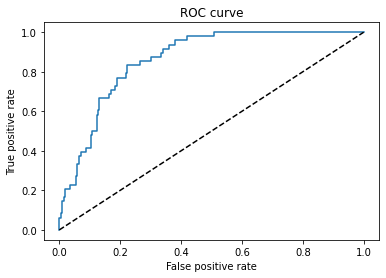

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

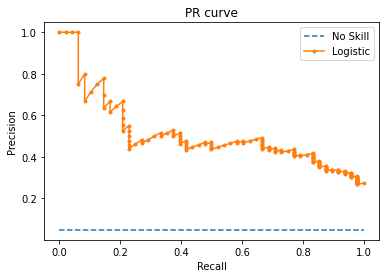

In [ ]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds1 = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [ ]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
#best_thresh = thresholds1[ix]
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.462061


In [ ]:
# best threshold using precision recall curve
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_thresh_precision = thresholds1[ix]
print(best_thresh_precision)
print(fscore)


0.6993805406564558
[0.42857143 0.42152466 0.42342342 0.42533937 0.42727273 0.42922374
 0.43119266 0.43317972 0.43518519 0.4372093  0.43925234 0.44131455
 0.44339623 0.44549763 0.44761905 0.44976077 0.45192308 0.45410628
 0.45631068 0.45853659 0.46078431 0.46305419 0.46534653 0.46766169
 0.46       0.46231156 0.46464646 0.46700508 0.46938776 0.47179487
 0.4742268  0.47668394 0.47916667 0.48167539 0.48421053 0.47619048
 0.4787234  0.48128342 0.48387097 0.48648649 0.48913043 0.48087432
 0.48351648 0.48618785 0.48888889 0.49162011 0.49438202 0.48587571
 0.48863636 0.49142857 0.48275862 0.48554913 0.48837209 0.49122807
 0.49411765 0.49704142 0.5        0.50299401 0.5060241  0.4969697
 0.5        0.50306748 0.50617284 0.50931677 0.5125     0.51572327
 0.51898734 0.52229299 0.52564103 0.51612903 0.51948052 0.52287582
 0.52631579 0.52980132 0.53333333 0.53691275 0.54054054 0.54421769
 0.54794521 0.55172414 0.55555556 0.54545455 0.53521127 0.53900709
 0.52857143 0.5323741  0.53623188 0.54014599

In [ ]:
df_scorecard = None
df_scorecard = summary_table
df_scorecard.reset_index(inplace = True)
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split('_').str[0]

In [ ]:
df_scorecard
# df_scorecard.to_excel("scorescard.xlsx")
# from google.colab import files
# files.download("scorescard.xlsx")

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.153836,Intercept,603.459867,603.0,-0.459867,598.0
1,1,gender_F,-0.230768,gender,-10.620409,-11.0,-0.379591,-11.0
2,2,gender_M,0.231483,gender,10.653280,11.0,0.346720,11.0
3,3,age_gens_baby_boomers,-0.101616,age,-4.676584,-5.0,-0.323416,-5.0
4,4,age_gens_gen_x,0.196702,age,9.052620,9.0,-0.052620,9.0
...,...,...,...,...,...,...,...,...
103,103,province_mean_encoding:<=0.07,-2.921866,province,-134.470021,-134.0,0.470021,-134.0
104,104,province_mean_encoding:0.07-0.12,-0.161741,province,-7.443616,-7.0,0.443616,-7.0
105,105,province_mean_encoding:0.12-0.181,0.480495,province,22.113329,22.0,-0.113329,22.0
106,106,province_mean_encoding:0.181-0.25,0.964040,province,44.367039,44.0,-0.367039,44.0


In [ ]:
    min_score = 300
    max_score = 850

    min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
    print("min_sum_coef is::",min_sum_coef)

    max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
    print("max_sum_coef is::",max_sum_coef)

    df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
    print("df_scorecard['Score - Calculation'] is::\n",df_scorecard['Score - Calculation'])

    df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
    print("========",df_scorecard.loc[0, 'Score - Calculation'])

    df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
    print("df_scorecard['Score - Preliminary'] is::",df_scorecard['Score - Preliminary'])

    min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
    max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()

print("min_sum_score_pre is::",min_sum_score_prel)
print("max_sum_score_prel is::",max_sum_score_prel)

min_sum_coef is:: -7.747641134039985
max_sum_coef is:: 4.203173618065119
df_scorecard['Score - Calculation'] is::
 0      -53.101816
1      -10.620409
2       10.653280
3       -4.676584
4        9.052620
          ...    
103   -134.470021
104     -7.443616
105     22.113329
106     44.367039
107     75.466140
Name: Score - Calculation, Length: 108, dtype: float64
======== 603.459866897407
df_scorecard['Score - Preliminary'] is:: 0      603.0
1      -11.0
2       11.0
3       -5.0
4        9.0
       ...  
103   -134.0
104     -7.0
105     22.0
106     44.0
107     75.0
Name: Score - Preliminary, Length: 108, dtype: float64
min_sum_score_pre is:: 300.0
max_sum_score_prel is:: 850.0


In [ ]:
    df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
    print("df_scorecard['Difference'] is::",df_scorecard['Difference'])

    df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
    print("df_scorecard['Score - Final'] is::",df_scorecard['Score - Final'])

    df_scorecard.loc[0, 'Score - Final'] = 598

    X_test_onehot.insert(0, 'Intercept', 1)
# X_test_woe_transformed
    scorecard_scores = df_scorecard['Score - Final']


    # scorecard_scores = scorecard_scores.values.reshape(21, 1)
    # y_scores = X_test_onehot.dot(scorecard_scores)



df_scorecard['Difference'] is:: 0     -0.459867
1     -0.379591
2      0.346720
3     -0.323416
4     -0.052620
         ...   
103    0.470021
104    0.443616
105   -0.113329
106   -0.367039
107   -0.466140
Name: Difference, Length: 108, dtype: float64
df_scorecard['Score - Final'] is:: 0      603.0
1      -11.0
2       11.0
3       -5.0
4        9.0
       ...  
103   -134.0
104     -7.0
105     22.0
106     44.0
107     75.0
Name: Score - Final, Length: 108, dtype: float64


In [ ]:
X_test_onehot.shape

(300, 108)

In [ ]:
scorecard_scores = scorecard_scores.values.reshape(108, 1)
y_scores = X_test_onehot.dot(scorecard_scores)
y_scores

,0
791,506.0
280,448.0
900,426.0
905,492.0
485,669.0
...,...
821,531.0
654,730.0
50,613.0
36,399.0


In [ ]:
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.153836,Intercept,603.459867,603.0,-0.459867,598.0
1,1,gender_F,-0.230768,gender,-10.620409,-11.0,-0.379591,-11.0
2,2,gender_M,0.231483,gender,10.653280,11.0,0.346720,11.0
3,3,age_gens_baby_boomers,-0.101616,age,-4.676584,-5.0,-0.323416,-5.0
4,4,age_gens_gen_x,0.196702,age,9.052620,9.0,-0.052620,9.0
...,...,...,...,...,...,...,...,...
103,103,province_mean_encoding:<=0.07,-2.921866,province,-134.470021,-134.0,0.470021,-134.0
104,104,province_mean_encoding:0.07-0.12,-0.161741,province,-7.443616,-7.0,0.443616,-7.0
105,105,province_mean_encoding:0.12-0.181,0.480495,province,22.113329,22.0,-0.113329,22.0
106,106,province_mean_encoding:0.181-0.25,0.964040,province,44.367039,44.0,-0.367039,44.0


In [ ]:
y_scores.max()

0    802.0
dtype: float64

In [ ]:
type(y_scores)

pandas.core.frame.DataFrame

In [ ]:
y_scores.to_excel("final_scores.xlsx")
from google.colab import files
files.download("final_scores.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_scores.min()

0    300.0
dtype: float64

In [ ]:
X_test_onehot

,Intercept,gender_F,gender_M,age_gens_baby_boomers,age_gens_gen_x,age_gens_gen_y,spending_sum:<=1900,spending_sum:1900-2600,spending_sum:2600-3500,spending_sum:3500-4400,spending_sum:4400-6100,spending_sum:>6100,spending_count:<=840,spending_count:840-970,spending_count:970-1050,spending_count:1050-1170,spending_count:1170-1290,spending_count:>1290,spending_mean:<=2,spending_mean:2-2.8,spending_mean:2.8-3.6,spending_mean:3.6-4.9,spending_mean:>4.9,spending_std:<=2.7,spending_std:2.7-4.3,spending_std:4.3-5.8,spending_std:5.8-7.9,spending_std:>7.9,spending_coefvar:<=0.8,spending_coefvar:0.8-1.3,spending_coefvar:1.3-1.9,spending_coefvar:1.9-2.6,spending_coefvar:>2.6,spending_skewness:<=1.9,spending_skewness:1.9-3.3,spending_skewness:3.3-5.2,spending_skewness:5.2-8.4,spending_skewness:>8.4,topup_sum:<=2100,topup_sum:2100-2900,...,calling_dur_sum:<=1250,calling_dur_sum:1250-2100,calling_dur_sum:2100-3000,calling_dur_sum:3000-4700,calling_dur_sum:>4700,calling_dur_mean:<=1.2,calling_dur_mean:1.2-2.1,calling_dur_mean:2.1-2.9,calling_dur_mean:2.9-4.4,calling_dur_mean:>4.4,calling_dur_std:<=2.7,calling_dur_std:2.7-4.2,calling_dur_std:4.2-5.8,calling_dur_std:5.8-7.9,calling_dur_std:>7.9,calling_dur_coefvar:<=0.9,calling_dur_coefvar:0.9-1.62,calling_dur_coefvar:1.62-2.6,calling_dur_coefvar:2.6-4.4,calling_dur_coefvar:>4.4,calling_dur_skewness:<=1.8,calling_dur_skewness:1.8-3.1,calling_dur_skewness:3.1-4.9,calling_dur_skewness:4.9-7.9,calling_dur_skewness:>7.9,calling_enp_loc:<=2.9,calling_enp_loc:2.9-3.05,calling_enp_loc:3.05-3.15,calling_enp_loc:3.15-3.27,calling_enp_loc:>3.27,age_years:<=28.5,age_years:28.5-36.4,age_years:36.4-45,age_years:45-53,age_years:>53,province_mean_encoding:<=0.07,province_mean_encoding:0.07-0.12,province_mean_encoding:0.12-0.181,province_mean_encoding:0.181-0.25,province_mean_encoding:>0.25
791,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
280,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
900,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
905,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
485,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
654,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
50,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
36,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
